# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 1: 데이터 전처리

## [미션]

단지별 등록 차량 수를 예측하기에 적합한 형태로 데이터 전처리를 수행합니다.

1) 필요한 변수를 추가하고 불필요한 변수를 제거합니다.
2) 단지별 데이터와 상세 데이터를 분리합니다.
3) 상세 데이터를 단지별로 집계합니다.
    - 단지별 총면적 집계
    - 전용면적구간 집계 (피벗형태)
    - 단지별 임대보증금, 임대료 평균 집계
4) 단지별 데이터와 집계 데이터를 하나로 합칩니다.
5) 변수 추가 (옵션)
    - 등록 차량수를 예측하기 위해 필요한 변수를 추가합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [718]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [720]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [722]:
# 한글 표시를 위한 라이브러리 설치
!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- 학습용 데이터(train.xlsx)를 읽어옵니다.
- 읽어온 데이터를 apart 데이터프레임으로 선언합니다.
- 평가용 데이터(test.xlsx) 파일은 모델 완성 후 사용할 미래의 데이터입니다.

#### 1) 데이터 불러오기

In [3]:
# 파일 불러오기
apart = pd.read_excel('train.xlsx')

In [9]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1157 non-null   object 
 1   단지명       1157 non-null   object 
 2   총세대수      1157 non-null   int64  
 3   전용면적별세대수  1157 non-null   int64  
 4   지역        1157 non-null   object 
 5   준공일자      1157 non-null   int64  
 6   건물형태      1135 non-null   object 
 7   난방방식      1082 non-null   object 
 8   승강기설치여부   1059 non-null   object 
 9   단지내주차면수   1157 non-null   int64  
 10  전용면적      1157 non-null   float64
 11  공용면적      1157 non-null   float64
 12  임대보증금     1157 non-null   int64  
 13  임대료       1157 non-null   int64  
 14  실차량수      1157 non-null   int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 135.7+ KB


#### 2) 기본 정보 조회

In [11]:
apart.loc[(apart['단지코드'] == 'C0001') & (apart['전용면적'] == 51.89)]

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109


In [13]:
apart['전용면적별세대수'].max()

1258

In [27]:
apart.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88


In [29]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1157 non-null   object 
 1   단지명       1157 non-null   object 
 2   총세대수      1157 non-null   int64  
 3   전용면적별세대수  1157 non-null   int64  
 4   지역        1157 non-null   object 
 5   준공일자      1157 non-null   int64  
 6   건물형태      1135 non-null   object 
 7   난방방식      1082 non-null   object 
 8   승강기설치여부   1059 non-null   object 
 9   단지내주차면수   1157 non-null   int64  
 10  전용면적      1157 non-null   float64
 11  공용면적      1157 non-null   float64
 12  임대보증금     1157 non-null   int64  
 13  임대료       1157 non-null   int64  
 14  실차량수      1157 non-null   int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 135.7+ KB


In [31]:
apart['단지코드'].value_counts()

단지코드
C0052    14
C0240    14
C0166    13
C0239    11
C0238     9
         ..
C0081     1
C0079     1
C0323     1
C0324     1
C1187     1
Name: count, Length: 345, dtype: int64

In [33]:
apart.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,1157.0,6.590752e+02,4.561106e+02,1.00,3.150000e+02,5.950000e+02,9.180000e+02,2.289000e+03
전용면적별세대수,1157.0,1.636914e+02,1.667664e+02,1.00,4.400000e+01,1.120000e+02,2.290000e+02,1.258000e+03
준공일자,1157.0,2.008667e+07,6.777985e+04,19920101.00,2.005031e+07,2.010042e+07,2.013121e+07,2.022071e+07
단지내주차면수,1157.0,6.822619e+02,4.733318e+02,10.00,3.080000e+02,6.290000e+02,9.110000e+02,4.553000e+03
전용면적,1157.0,5.156558e+01,1.824331e+01,17.59,3.948000e+01,4.690000e+01,5.981000e+01,1.393500e+02
공용면적,1157.0,2.056236e+01,5.164405e+00,5.85,1.699740e+01,2.038470e+01,2.372250e+01,4.276000e+01
임대보증금,1157.0,2.850789e+07,2.890687e+07,0.00,1.379700e+07,1.997300e+07,3.375300e+07,2.549220e+08
임대료,1157.0,2.259409e+05,1.768102e+05,0.00,1.177400e+05,1.842900e+05,2.634400e+05,1.058030e+06
실차량수,1157.0,6.507623e+02,3.905735e+02,21.00,3.200000e+02,6.260000e+02,8.940000e+02,1.657000e+03


In [35]:
apart.corr(numeric_only=True).style.background_gradient()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
총세대수,1.000000,0.486511,0.058568,0.615652,-0.206227,-0.016092,0.067881,0.078974,0.688783
전용면적별세대수,0.486511,1.000000,-0.052727,0.229355,-0.194478,-0.114391,-0.075221,-0.028003,0.294053
준공일자,0.058568,-0.052727,1.000000,0.307112,0.229243,0.319225,0.334364,0.363545,0.345515
단지내주차면수,0.615652,0.229355,0.307112,1.000000,0.302381,0.345131,0.305111,0.199081,0.890626
전용면적,-0.206227,-0.194478,0.229243,0.302381,1.000000,0.754058,0.553884,0.478109,0.314336
공용면적,-0.016092,-0.114391,0.319225,0.345131,0.754058,1.000000,0.516675,0.473151,0.349782
임대보증금,0.067881,-0.075221,0.334364,0.305111,0.553884,0.516675,1.000000,0.826746,0.350013
임대료,0.078974,-0.028003,0.363545,0.199081,0.478109,0.473151,0.826746,1.000000,0.325393
실차량수,0.688783,0.294053,0.345515,0.890626,0.314336,0.349782,0.350013,0.325393,1.000000


## 2. 데이터 전처리 ①

- 결측치 존재 여부를 확인하고 적절히 처리합니다.
- 필요한 변수를 추가하고, 불필요한 변수를 제거합니다.

### (1) 결측치 처리

- 결측치가 있는 지 확인합니다.

In [39]:
apart.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공용면적         0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

- 결측치는 적절한 값으로 채웁니다.
- 예를 들어 범주형 변수인 경우는 각 변수의 최빈값으로 채울 수 있습니다.

In [42]:
apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)
apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)
apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

In [44]:
apart.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        0
난방방식        0
승강기설치여부     0
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
실차량수        0
dtype: int64

### (2) 변수 추가

- '준공일자' 변수 값 앞 4 자리를 갖는 int 형 변수 '준공연도'를 추가합니다.
- 총면적 = (전용면적 + 공용면적) * 전용면적별세대수 공식에 따른'총면적' 변수를 추가합니다.

In [47]:
apart['준공일자'].head(2)

0    20131204
1    20131204
Name: 준공일자, dtype: int64

In [49]:
apart['준공연도'] = apart['준공일자'].astype(str).str[:4]
apart['총면적'] = (apart['전용면적'] + apart['공용면적'])*apart['전용면적별세대수']

In [51]:
apart.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013,569.9134


### (3) 불필요한 변수 제거

- '단지명' 변수는 단일값을 가지므로 제거합니다.
- '단지내주차면수' 변숫값을 기반으로 등록 차량수를 예측하는 것은 의미가 없으니, '단지내주차면수' 변수를 제거합니다.
- '준공연도' 변수를 추가했으니 '준공일자' 변수를 제거합니다.

In [54]:
drop_cols = ['단지명','단지내주차면수','준공일자']
apart.drop(columns=drop_cols,inplace=True)

In [56]:
apart.head(2)

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,78,35,서울,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,78,43,서울,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109,2013,3533.5078


## 3. 데이터 전처리 ②

- 단지별 데이터와 상세 데이터로 분리합니다.
- 상세 데이터를 3가지 형태로 집계합니다.
- 단지별 데이터와 상세 데이터 집계 결과를 조인(Merge) 합니다.

### (1) 데이터 분리

- 단지별 데이터를 갖는 data01 데이터프레임을 선언합니다.
- 상세 데이터를 갖는 data02 데이터프레임을 선언합니다.

#### 1) 단지별 데이터 분리

- 다음 열을 갖는 data01 데이터프레임으로 선언합니다.
    - '단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'
- data01 데이터프레임의 중복행을 제거합니다.
- 인덱스를 초기화 합니다. (단, 기존 인덱스 제거)
- 중복행 제거 여부를 필히 확인합니다.

In [62]:
data01 = apart.loc[:,['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']]
data01.drop_duplicates(inplace=True)
data01.reset_index(drop=True,inplace=True)
data01.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21


In [64]:
print(data01.duplicated())

0      False
1      False
2      False
3      False
4      False
       ...  
340    False
341    False
342    False
343    False
344    False
Length: 345, dtype: bool


In [66]:
data01.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21


In [68]:
data01.shape

(345, 8)

#### 2) 상세 데이터 분리
    
- 다음 열을 갖는 data02 데이터프레임으로 선언합니다.
    - '단지코드', '총전용면적', '총공용면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'

In [72]:
data02 = apart.loc[:,['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
data02.reset_index(drop=True,inplace=True)
data02.head()

,단지코드,총면적,전용면적별세대수,전용면적,공용면적,임대보증금,임대료
0,C0001,2490.2605,35,51.89,19.2603,50758000,620370
1,C0001,3533.5078,43,59.93,22.2446,63166000,665490
2,C0002,1151.4750,26,27.75,16.5375,63062000,458640
3,C0002,417.6918,9,29.08,17.3302,63062000,481560
4,C0003,569.9134,7,59.47,21.9462,72190000,586540


In [74]:
data02.shape

(1157, 7)

### (2) 상세 데이터 집계

- 앞에서 선언한 data02 데이터프레임을 대상으로 다음 3가지 형태로 집계합니다.
    - 단지코드별 총면적 합을 집계합니다.
    - 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계합니다.
    - 단지코드별 임대보증금, 임대료 평균을 집계합니다

#### 1) 단지코드별 총면적 합 집계

- 단지코드별 총면적 합을 집계합니다.
- 집계한 결과를 df_area 데이터프레임으로 선언합니다.

In [78]:
df_area = data02.groupby(by='단지코드')[['총면적']].sum()
df_area.head()

,총면적
단지코드,
C0001,6023.7683
C0002,1569.1668
C0003,7180.1396
C0004,47058.9273
C0006,543.0268


#### 2) 전용면적 구간별 집계 (피벗 형태)

- data02 데이터프레임에 전용면적을 몇몇 구간으로 나눈 범줏값을 갖는 변수를 추가합니다.
- 구간을 어떻게 나눌 지 충분히 고민해 봅니다.
    - 구간 예: 10-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-200 
- 추가할 변수 이름은 '전용면적구간'으로 합니다.
- 참고: pd.cut() 함수를 활용합니다.

In [82]:
data02['전용면적'].max()

139.35

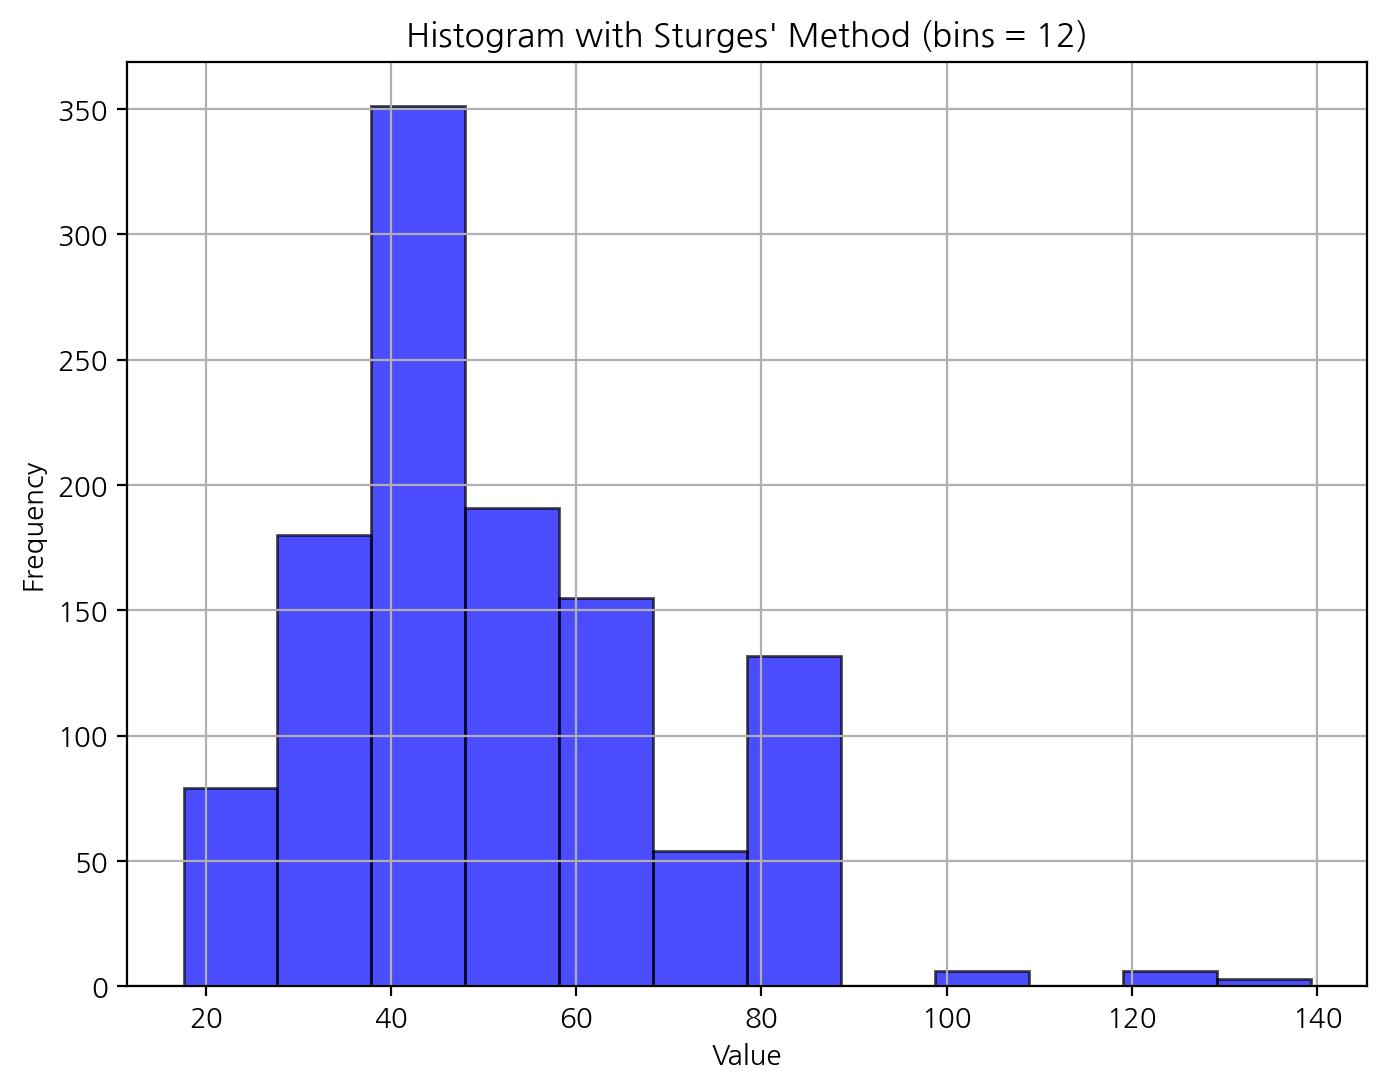

In [84]:
n = len(data02['전용면적'])
sturges_bins = int(np.ceil(np.log2(n) + 1))

# 히스토그램 그리기 (Sturges' Method 적용)
plt.figure(figsize=(8, 6))
plt.hist(data02['전용면적'], bins=sturges_bins, color='blue', alpha=0.7, edgecolor='black')
plt.title(f'Histogram with Sturges\' Method (bins = {sturges_bins})')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [85]:
# bin_list = [10, 30, 40, 50,60,70,80,200]
# label_list = ['면적10_30', '면적30_40', '면적40_50', '면적50-60', '면적60_70', '면적70_80', '면적80_200']
# data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

In [764]:
# bin_list = [0, 30, 37, 40, 48, 52, 70, 100, 200]
# label_list = ['면적0_30', '면적30_37', '면적37_40', '면적40_48', '면적48_52', '면적52_70', '면적70_100', '면적100_200']
# data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

In [ ]:
# from sklearn.preprocessing import KBinsDiscretizer

# # Reshape the data for the KBinsDiscretizer
# data = tmp[['전용면적']].values

# # Create and fit the KBinsDiscretizer
# n_bins = 12  # You can adjust the number of bins as needed
# kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# tmp['전용면적구간'] = kbd.fit_transform(data).astype(int)

# # Get the bin edges
# bin_edges = kbd.bin_edges_[0]

# # Display the sections
# tmp['전용면적구간'] = pd.cut(tmp['전용면적'], bins=bin_edges, include_lowest=True)
# section_counts = tmp['전용면적구간'].value_counts().sort_index()

# print(section_counts)

# bins = [0, 42.9, 51.97, 59.9, 68.603, 74.91, 84.083, 84.98, 139.35]


In [ ]:
# # Create a figure and a set of subplots.
# fig, ax = plt.subplots()

# # Generate a scatter plot.
# ax.scatter(data02.index, data02['전용면적'])

# # Setting the limits for y-axis.
# plt.ylim(0, 210)

# # Drawing horizontal lines at the given bin points.
# for bin in bins:
#     ax.axhline(y=bin, color='r')

# # Setting the title and labels.
# plt.title('Scatter plot of 전용면적')
# plt.xlabel('Index')
# plt.ylabel('전용면적')

# # Show the plot
# plt.show()

In [93]:
bin_list = [0, 42.9, 51.97, 59.9, 68.603, 74.91, 84.083, 84.98, 139.35]
label_list = ['면적0_42.9', '면적42.9_51.97', '면적51.97_59.9', '면적59.9_68.603', '면적68.603_74.91', '면적74.91_84.083', '면적84.083_84.98', '면적84.98_139.35']
data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

In [95]:
data02.head(20)

,단지코드,총면적,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,전용면적구간
0,C0001,2490.2605,35,51.89,19.2603,50758000,620370,면적42.9_51.97
1,C0001,3533.5078,43,59.93,22.2446,63166000,665490,면적59.9_68.603
2,C0002,1151.4750,26,27.75,16.5375,63062000,458640,면적0_42.9
3,C0002,417.6918,9,29.08,17.3302,63062000,481560,면적0_42.9
4,C0003,569.9134,7,59.47,21.9462,72190000,586540,면적51.97_59.9
5,C0003,489.4008,6,59.58,21.9868,72190000,586540,면적51.97_59.9
6,C0003,2366.2318,29,59.60,21.9942,72190000,586540,면적51.97_59.9
7,C0003,3754.5936,46,59.62,22.0016,72190000,586540,면적51.97_59.9
8,C0004,12230.0100,150,59.96,21.5734,65421000,651960,면적59.9_68.603
9,C0004,4989.9199,49,74.89,26.9451,99261000,962150,면적68.603_74.91


In [97]:
data02.shape

(1157, 8)

- 단지코드, 전용면적구간별 전용면적별세대수 합을 집계합니다.
- 집계 결과를 temp 데이터프레임으로 선언합니다.

In [100]:
temp = data02.groupby(by=['단지코드','전용면적구간'])[['전용면적별세대수']].sum()
temp

전용면적별세대수
단지코드  전용면적구간                  
C0001 면적0_42.9               0
      면적42.9_51.97          35
      면적51.97_59.9           0
      면적59.9_68.603         43
      면적68.603_74.91         0
...                        ...
C2349 면적59.9_68.603          0
      면적68.603_74.91         0
      면적74.91_84.083         0
      면적84.083_84.98         0
      면적84.98_139.35         0

[2760 rows x 1 columns]

- temp 데이터프레임을 피벗 형태로 변환하여 df_pivot 데이터프레임으로 선언합니다.
- 인덱스를 초기화합니다. (단, 인덱스였던 '단지코드'가 제거되면 안됨)
- 이후 작업의 편의를 위해 일반적인 데이터프레임 형태를 갖게 합니다.
- 참고: df2 = df1.pivot(index=?, columns=?, values=?) 형태로 pivot() 메서드를 사용합니다.
- 참고: df2.columns.name=None 형태의 구문을 사용해 열이름에 대한 이름을 제거합니다.

In [103]:
df_pivot = temp.pivot_table(index='단지코드', columns='전용면적구간', values='전용면적별세대수', aggfunc='sum')
df_pivot.columns.name=None

In [105]:
df_pivot.head()

,면적0_42.9,면적42.9_51.97,면적51.97_59.9,면적59.9_68.603,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35
단지코드,,,,,,,,
C0001,0,35,0,43,0,0,0,0
C0002,35,0,0,0,0,0,0,0
C0003,0,0,88,0,0,0,0,0
C0004,0,0,0,150,49,167,111,0
C0006,15,0,0,0,0,0,0,0


#### 3) 임대보증금, 임대료 평균 집계

- 단지코드별 임대보증금, 임대료 평균을 집계합니다.
- 집계 결과를 df_rent 데이터프레임으로 선언합니다.

In [839]:
df_rent_t=data02.groupby(['단지코드','전용면적별세대수'], as_index=False)[['임대보증금','임대료']].mean()
df_rent_t['임대보증금'] = df_rent_t['임대보증금'] * df_rent_t['전용면적별세대수']
df_rent_t['임대료'] = df_rent_t['임대료'] * df_rent_t['전용면적별세대수']
df_rent_t1 = df_rent_t.groupby(['단지코드'], as_index=False)[['임대보증금','임대료']].sum()
df_rent_t2 = df_rent_t.groupby(['단지코드'], as_index=False)[['전용면적별세대수']].sum()

df_rent_t = pd.merge(df_rent_t1, df_rent_t2, on='단지코드')
df_rent_t['임대보증금'] = df_rent_t['임대보증금'] / df_rent_t['전용면적별세대수']
df_rent_t['임대료'] = df_rent_t['임대료'] / df_rent_t['전용면적별세대수']
df_rent_t.drop(columns='전용면적별세대수', inplace=True)
df_rent_t.head()

,단지코드,임대보증금,임대료
0,C0001,5.759831e+07,645243.846154
1,C0002,6.306200e+07,464533.714286
2,C0003,7.219000e+07,586540.000000
3,C0004,9.158473e+07,877880.272537
4,C0006,5.446315e+07,330212.000000


In [107]:
df_rent = data02.groupby(by='단지코드')[['임대보증금','임대료']].mean()
df_rent.head()

,임대보증금,임대료
단지코드,,
C0001,5.696200e+07,642930.000000
C0002,6.306200e+07,470100.000000
C0003,7.219000e+07,586540.000000
C0004,1.015167e+08,950305.000000
C0006,5.522750e+07,340148.333333


In [109]:
df_rent.shape

(345, 2)

### (3) 집계 결과 합치기

- 위 과정에서 만든 df_area, df_pivot, df_rent 데이터프레임을 data01 데이터프레임과 조인(Merge)합니다.
- data01 데이터프레임이 기준 데이터프레임입니다.
- '단지코드' 변수가 조인 기준이 되며, how='left'를 지정합니다.
- 조인 결과를 base_data 데이터프레임으로 선언합니다.

In [112]:
# 열 이름 통일
df_area.columns = df_area.columns.str.strip()  # 공백 제거
df_pivot.columns = df_pivot.columns.str.strip()  # 공백 제거

In [114]:
base_data = df_area.merge(df_pivot,how='inner',left_index=True,right_index=True)
base_data = base_data.merge(df_rent,how='inner', left_index=True, right_index=True)
base_data = base_data.reset_index()
base_data.head()

,단지코드,총면적,면적0_42.9,면적42.9_51.97,면적51.97_59.9,면적59.9_68.603,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35,임대보증금,임대료
0,C0001,6023.7683,0,35,0,43,0,0,0,0,5.696200e+07,642930.000000
1,C0002,1569.1668,35,0,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,7180.1396,0,0,88,0,0,0,0,0,7.219000e+07,586540.000000
3,C0004,47058.9273,0,0,0,150,49,167,111,0,1.015167e+08,950305.000000
4,C0006,543.0268,15,0,0,0,0,0,0,0,5.522750e+07,340148.333333


In [116]:
base_data.isna().sum()

단지코드              0
총면적               0
면적0_42.9          0
면적42.9_51.97      0
면적51.97_59.9      0
면적59.9_68.603     0
면적68.603_74.91    0
면적74.91_84.083    0
면적84.083_84.98    0
면적84.98_139.35    0
임대보증금             0
임대료               0
dtype: int64

In [118]:
print(base_data.shape)
print(data01.shape)

(345, 12)
(345, 8)


In [120]:
base_data = data01.merge(base_data, how='inner')
base_data

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,면적0_42.9,면적42.9_51.97,면적51.97_59.9,면적59.9_68.603,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,6023.7683,0,35,0,43,0,0,0,0,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,1569.1668,35,0,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,7180.1396,0,0,88,0,0,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,47058.9273,0,0,0,150,49,167,111,0,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,543.0268,15,0,0,0,0,0,0,0,5.522750e+07,340148.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298,64622.2500,1479,0,6,0,0,0,0,0,7.595571e+06,104975.714286
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258,57616.8100,1369,0,17,0,0,0,0,0,8.092875e+06,111848.750000
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243,37398.7200,956,0,0,0,0,0,0,0,9.931000e+06,134540.000000
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47,5581.8024,120,0,0,0,0,0,0,0,2.515500e+06,50040.000000


In [122]:
base_data.isna().sum()

단지코드              0
총세대수              0
지역                0
준공연도              0
건물형태              0
난방방식              0
승강기설치여부           0
실차량수              0
총면적               0
면적0_42.9          0
면적42.9_51.97      0
면적51.97_59.9      0
면적59.9_68.603     0
면적68.603_74.91    0
면적74.91_84.083    0
면적84.083_84.98    0
면적84.98_139.35    0
임대보증금             0
임대료               0
dtype: int64

## 4. 데이터 셋 저장

- joblib.dump() 함수를 사용하여 최종 데이터 셋을 파일로 저장합니다.
- 파일 이름은 base_data1.pkl로 합니다.

In [837]:
# 파일로 저장
joblib.dump(base_data, 'team9_base_data1.pkl')

['team9_base_data1.pkl']

In [124]:
# 파일로 저장
joblib.dump(base_data, 'team9_base_data1_binchange.pkl')

['team9_base_data1_binchange.pkl']